In [107]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import cv2
import json
import os
import datetime

In [96]:
#import json file with transformation info and tabulate
with open('/Users/turnerb/Desktop/code/image_reg/quickNII_reg/310122_mostrecent.json') as fp:
  bla = json.load(fp)

slice_coord = pd.DataFrame(columns=['filename','ox', 'oy', 'oz', 'ux', 'uy', 'uz', 'vx', 'vy', 'vz', 'markers', 'height', 'width'], dtype=int)
for slice in bla["slices"]:
    anchoring = slice["anchoring"]
    slice_coord = slice_coord.append({'filename': slice["filename"], 'ox': (anchoring[0]), 'oy': (anchoring[1]), 'oz': (anchoring[2]), 'ux': (anchoring[3]), 'uy': (anchoring[4]), 'uz': (anchoring[5]), 'vx': (anchoring[6]), 'vy': (anchoring[7]), 'vz': (anchoring[8]), 'markers': (slice["markers"]),'height': (slice["height"]), 'width': (slice["width"])},ignore_index=True)


In [92]:
#incorporate allen conversion units, and subsequently also incorporate functions from NITRC.org 
allen_matrix_conv = [[0, 0, 25, 0],
                    [-25, 0, 0, 0],
                    [0, -25, 0, 0],
                    [13175, 7975, 0, 1]]

In [101]:
   def triangulate(w,h,markers):
       vertices=[[-0.1*w,-0.1*h,-0.1*w,-0.1*h],
                 [ 1.1*w,-0.1*h, 1.1*w,-0.1*h],
                 [-0.1*w, 1.1*h,-0.1*w, 1.1*h],
                 [ 1.1*w, 1.1*h, 1.1*w, 1.1*h]]
       edges=[0]*((len(markers)+4)*(len(markers)+4-1)//2)
       triangles=[Triangle(0,1,2,vertices,edges),Triangle(1,2,3,vertices,edges)]
       edges[0]=edges[1]=edges[4]=edges[5]=2
       for marker in markers:
           x,y=marker[2:4]
           found=False
           keep=[]
           remove=[]
           for triangle in triangles:
               if not found and triangle.intriangle(x,y):
                   found=True
               if triangle.incircle(x,y):
                   remove.append(triangle)
               else:
                   keep.append(triangle)
           if found:
               for triangle in remove:
                   triangle.removeedges()
           else:
               keep.extend(remove)
           triangles=keep
           vcount=len(vertices)
           vertices.append(marker)
           for i in range(vcount-1):
               for j in range(i+1,vcount):
                   if edges[edgeindex(i,j)]==1:
                       triangles.append(Triangle(i,j,vcount,vertices,edges))
       return triangles
           
   def transform(triangulation,x,y):
       for triangle in triangulation:
           uv1=triangle.intriangle(x,y)
           if uv1:
               return (triangle.A[0]
                       +(triangle.B[0]-triangle.A[0])*uv1[0]
                       +(triangle.C[0]-triangle.A[0])*uv1[1],
                       triangle.A[1]
                       +(triangle.B[1]-triangle.A[1])*uv1[0]
                       +(triangle.C[1]-triangle.A[1])*uv1[1])
   
   def forwardtransform(triangulation,x,y):
       for triangle in triangulation:
           uv1=triangle.inforward(x,y)
           if uv1:
               return (triangle.A[2]
                     +(triangle.B[2]-triangle.A[2])*uv1[0]
                     +(triangle.C[2]-triangle.A[2])*uv1[1],
                       triangle.A[3]
                     +(triangle.B[3]-triangle.A[3])*uv1[0]
                     +(triangle.C[3]-triangle.A[3])*uv1[1])

 

In [97]:
   def inv3x3(m):
       det = m[0][0] * (m[1][1] * m[2][2] - m[2][1] * m[1][2])\
           - m[0][1] * (m[1][0] * m[2][2] - m[1][2] * m[2][0])\
           + m[0][2] * (m[1][0] * m[2][1] - m[1][1] * m[2][0])
       if det == 0:
           return None
       return [[(m[1][1] * m[2][2] - m[2][1] * m[1][2]) / det,
                (m[0][2] * m[2][1] - m[0][1] * m[2][2]) / det,
                (m[0][1] * m[1][2] - m[0][2] * m[1][1]) / det],
               [(m[1][2] * m[2][0] - m[1][0] * m[2][2]) / det,
                (m[0][0] * m[2][2] - m[0][2] * m[2][0]) / det,
                (m[1][0] * m[0][2] - m[0][0] * m[1][2]) / det],
               [(m[1][0] * m[2][1] - m[2][0] * m[1][1]) / det,
                (m[2][0] * m[0][1] - m[0][0] * m[2][1]) / det,
                (m[0][0] * m[1][1] - m[1][0] * m[0][1]) / det]]
   
   def rowmul3(v,m):return [sum(v[j]*m[j][i] for j in range(3)) for i in range(3)]
   def distsquare(ax,ay,bx,by):return (ax-bx)*(ax-bx)+(ay-by)*(ay-by)
   def edgeindex(a,b):i=min(a,b);j=max(a,b);return j*(j-1)//2+i
   
   class Triangle:
       def __init__(self,a,b,c,vlist,elist):
           self.A=vlist[a]
           self.B=vlist[b]
           self.C=vlist[c]
           self.elist=elist
           self.edges=[edgeindex(a,b),
                       edgeindex(a,c),
                       edgeindex(b,c)]
           for edge in self.edges:
               elist[edge]+=1
           ax,ay=self.A[0:2]
           bx,by=self.B[0:2]
           cx,cy=self.C[0:2]
           self.forwarddecomp=inv3x3([[bx-ax,by-ay,0],
                                      [cx-ax,cy-ay,0],
                                      [ax,ay,1]])
           ax,ay=self.A[2:4]
           bx,by=self.B[2:4]
           cx,cy=self.C[2:4]
           self.decomp=inv3x3([[bx-ax,by-ay,0],
                               [cx-ax,cy-ay,0],
                               [ax,ay,1]])
           a2=distsquare(bx,by,cx,cy)
           b2=distsquare(ax,ay,cx,cy)
           c2=distsquare(ax,ay,bx,by)
           fa=a2*(b2+c2-a2)
           fb=b2*(c2+a2-b2)
           fc=c2*(a2+b2-c2)
           self.den=fa+fb+fc
           self.Mdenx=fa*ax+fb*bx+fc*cx
           self.Mdeny=fa*ay+fb*by+fc*cy
           self.r2den=distsquare(ax*self.den,ay*self.den,self.Mdenx,self.Mdeny)
           
       def removeedges(self):
           for edge in self.edges:
               self.elist[edge]-=1
           del self.edges
           del self.elist
       
       def incircle(self,x,y):
           return distsquare(x*self.den,y*self.den,self.Mdenx,self.Mdeny)<self.r2den
       
       def intriangle(self,x,y):
           uv1=rowmul3([x,y,1],self.decomp)
           if 0<=uv1[0]<=1 and 0<=uv1[1]<=1 and uv1[0]+uv1[1]<=1:
               return uv1
       
       def inforward(self,x,y):
           uv1=rowmul3([x,y,1],self.forwarddecomp)
           if 0<=uv1[0]<=1 and 0<=uv1[1]<=1 and uv1[0]+uv1[1]<=1:
               return uv1

In [143]:
savingpath = ('/Users/turnerb/Desktop/code/image_reg/allen_ccf_coord')
os.chdir(savingpath)

for i, row in slice_coord['filename'].iteritems():
    print('Performing non-linear deformation for %s. %s' % 
            (row[:-len('.jpg')], datetime.datetime.now().strftime('%H:%M:%S')), flush=True)
    which = slice_coord.iloc[i]
    x_val = list(range(0, which['width']))
    y_val = list(range(0, which['height']))
    coord = np.meshgrid(x_val, y_val)
    width=which['width']
    height=which['height']
    newcoord=[]
#perform non-linear deformation of coordinates on each set of section image pixels according info in json file.
    triangulation=triangulate(width,height,which["markers"])
    for x, y in np.nditer(coord):
        i,j=transform(triangulation,x,y)
        nc = (i,j)
        newcoord.append(nc)
#make  new x y matrices of containing new non-linearly deformed coordinates   
    gi = pd.DataFrame(newcoord)
    Xt = np.reshape(np.array(gi[0]), (height, width))
    Yt = np.reshape(np.array(gi[1]), (height, width))

#now transform the deformed and registered quickNII image section coordinates to allen ccf     
    print('Converting to Allen Coordinates . %s' % 
            datetime.datetime.now().strftime('%H:%M:%S'), flush=True)
    U_V_O_vector = [[which['ux'], which['uy'], which['uz']],
                    [which['vx'], which['vy'], which['vz']],
                    [which['ox'], which['oy'], which['oz']]]
#generate 3D voxels from pixel coordinates for each file
    [xv,  yv,  zv] = np.matmul([(XX/which['width']),  (YY/which['height']),  1 ], U_V_O_vector)
#transform into allen coord
    filename = 'allen_ccf_converted_%s' %row[:-len('.jpg')]
    [xa, ya, za, one] = np.matmul([xv,  yv,  zv, 1], allen_matrix_conv)
    allen_vox = [xa, ya, za, one]
    np.save(filename, allen_vox)
                    

Performing non-linear deformation for brain1_s001. 18:02:17
Converting to Allen Coordinates . 18:03:40
Performing non-linear deformation for brain1_s002. 18:03:40


/Users/turnerb/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/Users/turnerb/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Converting to Allen Coordinates . 18:06:14
Performing non-linear deformation for brain1_s003. 18:06:14
Converting to Allen Coordinates . 18:07:35
Performing non-linear deformation for brain1_s004. 18:07:35
Converting to Allen Coordinates . 18:09:02
Performing non-linear deformation for brain1_s005. 18:09:02
Converting to Allen Coordinates . 18:09:56
Performing non-linear deformation for brain1_s006. 18:09:57
Converting to Allen Coordinates . 18:12:31
Performing non-linear deformation for brain1_s007. 18:12:31
Converting to Allen Coordinates . 18:14:29
Performing non-linear deformation for brain1_s008. 18:14:29
Converting to Allen Coordinates . 18:18:36
Performing non-linear deformation for brain1_s009. 18:18:36
Converting to Allen Coordinates . 18:22:20
Performing non-linear deformation for brain1_s010. 18:22:20
Converting to Allen Coordinates . 18:24:34
Performing non-linear deformation for brain1_s011. 18:24:34
Converting to Allen Coordinates . 18:30:43
Performing non-linear deformat

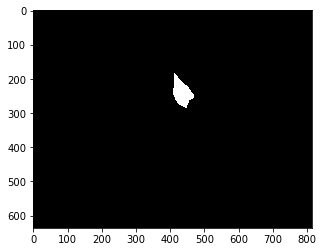

In [141]:
newpath = ('/Users/turnerb/Desktop/code/image_reg/')
os.chdir(newpath)

[xa, ya, za, one] = np.load('allen_ccf_coord/allen_ccf_converted_brain1_s006.npy')

roi = cv2.imread('rois/s006_tube59.png')
plt.imshow(roi)
roi.shape
roi = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
thresh = 127
roi = cv2.threshold(roi, thresh, 1, cv2.THRESH_BINARY)[1]
allencoord_roixa = roi*xa



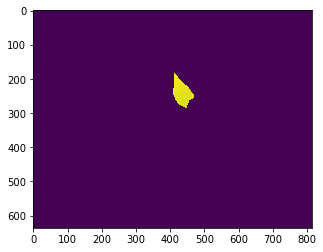

In [142]:
plt.imshow(allencoord_roixa)

#now create 3D volumes extending the size to up to the depth of the next slice

In [144]:
[xa, ya, za, one]

[array([[11200.46116897, 11198.49952748, 11196.53788599, ...,
          9605.64663704,  9603.68499555,  9601.72335406],
        [11199.56692796, 11197.60528647, 11195.64364498, ...,
          9604.75239602,  9602.79075453,  9600.82911304],
        [11198.67268694, 11196.71104545, 11194.74940396, ...,
          9603.85815501,  9601.89651352,  9599.93487203],
        ...,
        [10634.40660619, 10632.44496469, 10630.4833232 , ...,
          9039.59207425,  9037.63043276,  9035.66879127],
        [10633.51236517, 10631.55072368, 10629.58908219, ...,
          9038.69783323,  9036.73619174,  9034.77455025],
        [10632.61812415, 10630.65648266, 10628.69484117, ...,
          9037.80359222,  9035.84195073,  9033.88030924]]),
 array([[-2408.41934395, -2408.09808899, -2407.77683404, ...,
         -2147.23906524, -2146.91781028, -2146.59655533],
        [-2389.69688573, -2389.37563078, -2389.05437582, ...,
         -2128.51660702, -2128.19535207, -2127.87409711],
        [-2370.97442751, 